In [3]:
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from keras import layers
from sklearn import metrics
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(221)


SymbolAlreadyExposedError: Symbol arg_max is already exposed as ().

In [ ]:
def sliding_window(X, Y, size, stride):
    X_window = []
    y_window = []
    for i in range(len(X)):
        for j in range(0, len(X[i]) - (3*stride) - size + 1, stride):
            y_window.append(Y[i])
            X_window.append(X[i][j:j + size])
    return np.array(X_window), np.array(y_window)


def extract_features(csv_files):
    y_train = []
    X_train = []
    walking_rows = 0
    walking_files = 0
    logout_rows = 0
    logout_files = 0
    grenade_rows = 0
    grenade_files = 0
    reload_rows = 0
    reload_files = 0
    shield_rows = 0
    shield_files = 0
    for i in tqdm(range(len(csv_files)-1)):
        csv_file = csv_files[i]
        cols = ['timestamp', 'act_id', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
        action_raw = pd.read_csv(csv_file, dtype=np.int32, names=cols, usecols=lambda x: x not in ['timestamp', 'act_id'])
        labels = pd.read_csv(csv_file, header=None, names=cols, usecols=['act_id'])
        df = labels.head(1)
        # if action_raw.shape[0] < 100:
        #     action_raw = action_raw.reindex(range(100), fill_value=0)
        if df['act_id'].values == 0:
            action = 0
            walking_rows += action_raw.shape[0]
            walking_files += 1
        if df['act_id'].values == 1:
            action = 1
            grenade_rows += action_raw.shape[0]
            grenade_files += 1
        if df['act_id'].values == 2:
            action = 2
            reload_rows += action_raw.shape[0]
            reload_files += 1
            # action_raw = action_raw.reindex(range(100), fill_value=0)
        if df['act_id'].values == 3:
            action = 3
            shield_rows += action_raw.shape[0]
            shield_files += 1
            # action_raw = action_raw.reindex(range(100), fill_value=0)
            # print(action_raw.to_string())
        if df['act_id'].values == 4:
            action = 4
            logout_rows += action_raw.shape[0]
            logout_files += 1
        y_train.append(action)
        X_train.append(action_raw.values)

    logout_average = logout_rows / logout_files
    grenade_average = grenade_rows / grenade_files
    reload_average = reload_rows / reload_files
    shield_average = shield_rows / shield_files
    walking_average = walking_rows / walking_files
    print("Logout average rows:" + str(logout_average))
    print("Grenade average rows:" +str(grenade_average))
    print("Reload average rows:" + str(reload_average))
    print("Shield average rows:" + str(shield_average))
    print("Walking average rows:" + str(walking_average))
    y_train = to_categorical(y_train, 5)
    return X_train, np.array(y_train)


def scaling(x, seed, sigma=0.1):
    np.random.seed(seed)
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0], x.shape[2]))
    return np.multiply(x, factor[:, np.newaxis, :])


def magnitude_warp(x, seed, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    np.random.seed(seed)
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot + 2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2], 1)) * (np.linspace(0, x.shape[1] - 1., num=knot + 2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array(
            [CubicSpline(warp_steps[:, dim], random_warps[i, :, dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper

    return ret


def time_warp(x, seed, sigma=0.2, knot=4):
    from scipy.interpolate import CubicSpline
    orig_steps = np.arange(x.shape[1])
    np.random.seed(seed)
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot + 2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2], 1)) * (np.linspace(0, x.shape[1] - 1., num=knot + 2))).T

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:, dim], warp_steps[:, dim] * random_warps[i, :, dim])(orig_steps)
            scale = (x.shape[1] - 1) / time_warp[-1]
            ret[i, :, dim] = np.interp(orig_steps, np.clip(scale * time_warp, 0, x.shape[1] - 1), pat[:, dim]).T
    return ret


def window_warp(x, window_ratio=0.5, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio * x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)

    window_starts = np.random.randint(low=1, high=x.shape[1] - warp_size - 1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)

    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i], dim]
            window_seg = np.interp(np.linspace(0, warp_size - 1, num=int(warp_size * warp_scales[i])), window_steps,
                                   pat[window_starts[i]:window_ends[i], dim])
            end_seg = pat[window_ends[i]:, dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))
            ret[i, :, dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1] - 1., num=warped.size),
                                       warped).T
    return ret


def augment(x, seed):
    x = np.concatenate([np.array(x[:, :, :3]), np.array(magnitude_warp(x[:, :, 3:], seed))], axis=-1)
    x = np.concatenate([np.array(x[:, :, :3]), np.array(scaling(x[:, :, 3:], seed, sigma=0.1))], axis=-1)
    # x = np.concatenate([np.array(x[:, :, :3]), np.array(time_warp(x[:, :, 3:], seed))], axis=-1)
    w_ratio = np.random.uniform(0.4, 0.6)
    w_scale = np.arange(0.2, 4, 0.2)
    x = window_warp(x, window_ratio=w_ratio, scales=w_scale)
    return x

In [ ]:
warnings.filterwarnings('ignore')
DATA_DIR = os.getcwd()
data_files = sorted(glob.glob(os.path.join(DATA_DIR, "data_03_29_to_04_08/*.csv")))
X_train, y_train = extract_features(data_files)


100%|██████████| 3204/3204 [00:10<00:00, 306.65it/s]

Logout average rows:91.81645569620254
Grenade average rows:77.79666160849773
Reload average rows:70.46125
Shield average rows:70.50560398505604
Walking average rows:70.57692307692308


In [ ]:
weights = {}
for i in range(5):
    weights[i] = 1/y_train[:, i].sum()

WINDOW_SIZE = 45
STRIDE = 5
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, y_train_initial, test_size=0.2, stratify=y_train_initial, random_state=19)

# print(np.array(X_train))
X_train, y_train = sliding_window(X_train, y_train, WINDOW_SIZE, STRIDE)
X_test, y_test = sliding_window(X_test, y_test, WINDOW_SIZE, STRIDE)
X_val, y_val = sliding_window(X_val, y_val, WINDOW_SIZE, STRIDE)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7440, 45, 6)
(1861, 45, 6)
(2349, 45, 6)
(7440, 5)
(1861, 5)
(2349, 5)


In [ ]:
X_aug1 = augment(X_train, 1)
X_aug2 = augment(X_train, 2)
X_aug3 = augment(X_train, 3)
x_args = (X_train, X_aug1, X_aug2, X_aug3)
X_train = np.concatenate(x_args, axis=0)
y_args = (y_train, y_train, y_train, y_train)
y_train = np.concatenate(y_args, axis=0)
X_train, X_test, X_val = np.asarray(np.float32(X_train) / 4096), np.asarray(np.float32(X_test) / 4096), \
                         np.asarray(np.float32(X_val) / 4096)
print(X_train.shape)
print(y_train.shape)


np.save("x_test.npy", X_test)
np.save("y_test.npy", y_test)

(29760, 45, 6)
(29760, 5)


In [ ]:
model = keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=15, activation='relu', input_shape=(45, 6), strides=1))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 31, 64)            5824      
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 6,149
Trainable params: 6,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0, verbose=1)
Callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
mo_fitt = model.fit(X_train, y_train, epochs=5000, validation_data=(X_val, y_val), callbacks=[Callback, reduce_lr],
                    verbose=1, batch_size=32, class_weight=weights)
model.summary()

Epoch 1/5000
930/930 [==============================] - 3s 3ms/step - loss: 5.2154e-04 - accuracy: 0.8868 - val_loss: 0.2226 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 2/5000
930/930 [==============================] - 2s 2ms/step - loss: 3.0413e-04 - accuracy: 0.9344 - val_loss: 0.1632 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 3/5000
930/930 [==============================] - 2s 2ms/step - loss: 2.4509e-04 - accuracy: 0.9462 - val_loss: 0.1841 - val_accuracy: 0.9334 - lr: 0.0010
Epoch 4/5000
930/930 [==============================] - 2s 3ms/step - loss: 2.0736e-04 - accuracy: 0.9546 - val_loss: 0.1831 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 5/5000
930/930 [==============================] - 2s 3ms/step - loss: 1.8616e-04 - accuracy: 0.9587 - val_loss: 0.1327 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 6/5000
930/930 [==============================] - 2s 2ms/step - loss: 1.6834e-04 - accuracy: 0.9638 - val_loss: 0.1308 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 7/5000
930/930 [============

In [ ]:
accuracy = mo_fitt.history['accuracy']
loss = mo_fitt.history['loss']
validation_loss = mo_fitt.history['val_loss']
validation_accuracy = mo_fitt.history['val_accuracy']

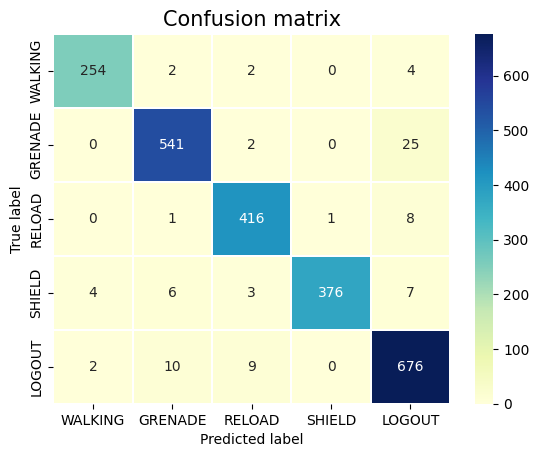

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       262
           1       0.97      0.95      0.96       568
           2       0.96      0.98      0.97       426
           3       1.00      0.95      0.97       396
           4       0.94      0.97      0.95       697

    accuracy                           0.96      2349
   macro avg       0.97      0.96      0.97      2349
weighted avg       0.96      0.96      0.96      2349



In [ ]:
predictions = model.predict(X_test)
class_labels = ["WALKING", "GRENADE", "RELOAD", "SHIELD", "LOGOUT"]

max_predictions = np.argmax(predictions, axis=1)
max_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(max_labels, max_predictions)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, linewidths=0.1, fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(max_labels, max_predictions))

In [ ]:
def save_model(model):
    for i in range(len(model.layers)):
        # skip global pooling layer
        if i == 1:
            continue
        layer = model.layers[i].get_weights()
        weights = layer[0]
        biases = layer[1]
        if i == 0:
            name = "cnn"
            weights = np.transpose(weights, (2, 0, 1))
        else:
            name = "dense"
            weights = np.transpose(weights, (1, 0))

        # save weights and biases to file
        np.save(f"{name}_weights.npy", weights)
        np.save(f"{name}_bias.npy", biases)

In [ ]:
save_model(model)